This notebook contains four sections:
1. __Overview__: statistics about the Processing Database.
2. __Genre Ordering__: how should we sort genres when creating visualizations?
3. __Conclusions__: assessment and saving.
4. __Appendix__: Graphs, graphs, and graphs.

# Overview

Starting with some basic information to orient ourselves to the data...

In [1]:
from bmb        import ProcessingDB
from matplotlib import pyplot       as plt
import numpy    as     np

db = ProcessingDB()

genre_combinations = db.genre_combinations( db.films_for_analysis )
num_films          = len( genre_combinations)
num_genre_labels   = sum( map( len, genre_combinations))

print( f"{num_films       } films for analysis in the processing database")
print( f"{num_genre_labels} genre-labels assigned")
print( f"{num_genre_labels / num_films :.2f} average genres per film")

7879 films for analysis in the processing database
17737 genre-labels assigned
2.25 average genres per film


Next, we pre-calculate some useful quantities from `genre_combinations` by running two functions defined in the `source` direvtory.  The variables `cc` and `ccc` are used repeatedly in this notebook, so it is important to understand their contents:
* `cc` is a dictionary that maps each genre to the number of films with that genre-label.
* `ccc` is a dictionary-of-dictionaries.  The two keys form a genre pair, so `ccc[ 'Action'][ 'Musical']` contains the number of films that are labeled with both genres, possibly among others.  The key relationship is commutative, meaning `ccc[ 'Musical'][ 'Action']` is the same number.

In [2]:
from bmb.source.analysis import category_count, category_coincidence_count

cc  = category_count(             genre_combinations)
ccc = category_coincidence_count( genre_combinations)

Plotting the contents of `cc` will show the relative frquency of the genres.

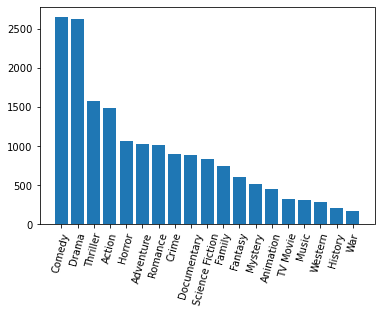

In [3]:
genres_by_count = *( t[0] for t in sorted(cc.items(), key=lambda x: -x[1])),
genre_counts    = *( t[1] for t in sorted(cc.items(), key=lambda x: -x[1])),

plt.xticks(ticks=np.arange( len( genres_by_count)), labels=genres_by_count, rotation= 75)
plt.bar( genres_by_count, genre_counts)
plt.show()

# Genre Ordering

## Motivation

The paired-distribution of genres will be presented using a _heatmap_, implemented in `bmb/source/analysis/visualizations.py`.  By examining the two defualt genre-orderings, alphabetical and by count, we will see the need for a new ordering.  Beginning with an alphabetical sort:

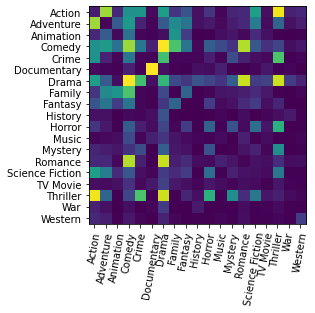

In [4]:
from bmb.source.analysis import categorical_heatmap
alphabetical = sorted( ccc.keys())
categorical_heatmap( ccc, order=alphabetical)
plt.show()

While sorting the genres alphabetically makes it easy to find a specific pairing, the positioning of the squares does not supports only trivial conclusions, such as _Comedy is more often paired with a genre beginning with A than a genre beginning with W_.  It might be true, but it isn't very useful.

Next, we will try sorting the genres by how often they appear in the data base:

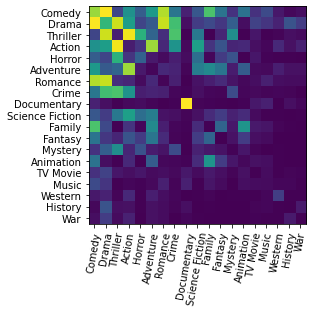

In [5]:
categorical_heatmap( ccc, order=genres_by_count)
plt.show()

This visualization is better, but there are two shortcomings:
1. The "interesting region" of the graph is crammed into the upper-left corner.  This is made worse by the fact that the graph is symmetric about the $genre = genre$ axis.
1. _Documentary_ films are almost always single-genre and have approximately the median frquency, which creates a cross of with almost no values in the middle of the graph.  In order to prevent "dead zones" from having a central place in the visualization, genres that are rarely grouped with others (such as _Documentary_) should be located near the edges of the heatmap.

From this we can conclude that **a good genre-ordering should keep strongly-connected genres together.**

## Algorithm

With the above objective in mind, the following algorithm will be used to construct a "chain" of genres
1. Initialize the chain with the two most connected genres.
1. While the chain does not contain all genres:
    1. Find the strongest connection between one of the two genres at the edge of the chain and any of the unused genres.
    1. If the connection includes the lower-edge-genre, add the new genre to the bottom of the chain.
    1. If the connection includes the upper-edge-genre, add the new genre to the top of the chain.

In [6]:
def strongest_connection( connection_strength, include=list(), exclude=list()):
    iterator_1 = include if include else connection_strength.keys()
    iterator_2 = [ node for node in connection_strength.keys() if node not in include and node not in exclude]
    strongest = None
    for node_1 in iterator_1:
        for node_2 in iterator_2:
            current = connection_strength[ node_1][ node_2]
            if strongest is None or current > strongest and node_1 != node_2:
                return_val_1, return_val_2, strongest = node_1, node_2, current
    return return_val_1, return_val_2

def construct_chain( connection_strength):
    LOWER_LIMIT, UPPER_LIMIT = 0, 1
    strongest_connection_1, strongest_connection_2 = strongest_connection( connection_strength)
    chain = {
        LOWER_LIMIT: strongest_connection_1,
        UPPER_LIMIT: strongest_connection_2  }

    while len( chain) < len( alphabetical):
        lower_edge = chain[ LOWER_LIMIT]
        upper_edge = chain[ UPPER_LIMIT]
        chain_edge, new_node = strongest_connection( 
            connection_strength, 
            include=(lower_edge, upper_edge),
            exclude=[ chain[i] for i in range(LOWER_LIMIT + 1, UPPER_LIMIT)])

        if chain_edge == lower_edge:
            LOWER_LIMIT -= 1
            chain[ LOWER_LIMIT] = new_node
        else:
            UPPER_LIMIT += 1
            chain[ UPPER_LIMIT] = new_node
    return tuple(map(lambda t: t[1], sorted(chain.items(), key=lambda x:x[0])))

Using the `construct_chain` function, I have been able to evaluate several different `connection_strength` mappings.  I have settled on one, which is presented below.

## Connection Strength

The connection strength is determined by the following function, which was selected to take into account both the size of the genres and the level of dependence between them.
 
$$
ConnectionStrength( A, B) = (|A| + |B|) \cdot (Prob( A \land B) - Prob(A) \cdot Prob(B))
$$

I may be changing the `connection_strength` mapping in the future, but the currently preferred ordering will always be returned  by the `ProcessingDB.genre_order` property.  If I do change the mapping, this version will be placed in the appendix at the end of this notebook.

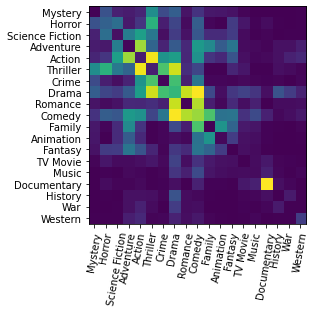

In [7]:
import math
from collections import defaultdict

genre_probability  = { category : count / num_films for category, count in cc.items()}

conditional_probability = {
    outer_category : {
        inner_category : count / num_films
        for inner_category, count in sub_dictionary.items() } 
    for outer_category, sub_dictionary in ccc.items() }

delta = {
    outer : {
        inner : probability - genre_probability[ outer] * genre_probability[ inner]
        for inner, probability in sub_dictionary.items() } 
    for outer, sub_dictionary in conditional_probability.items() }

connection_strength = defaultdict( dict)
for genre_1 in alphabetical:
    for genre_2 in alphabetical:
        connection_strength[ genre_1][ genre_2] = (cc[genre_1] + cc[genre_2]) * delta[ genre_1][ genre_2]
        
new_order = construct_chain( connection_strength)
categorical_heatmap(ccc, order=new_order)
plt.show()

# Conclusion
## Assessment

The ordering presented above accomplishes the stated objectives.
1. __Poorly connected genres, such as _Documentary_, are moved to the periphery.__  In fact, every genre after _TV Movie_ is either tiny or mostly independent of the other genres.
2. __Adjacent genres are related.__  Almost every connected pair of genres is a common genre pairing.
3. __Larger genres have been given a more central focus.__. The current ordering is pretty good in this regard, but not perfect, as demonstrated by the histogram below.

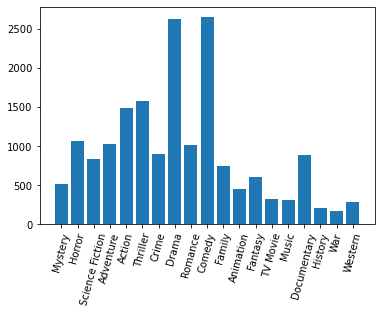

In [8]:
genre_counts = *( cc[genre] for genre in new_order),
plt.xticks(ticks=np.arange( len( new_order)), labels=new_order, rotation= 75)
plt.bar( new_order, genre_counts)
plt.show()

## Saving the Results

The genre ordering found in this notebook is saved in the `GenreOrdering` table of the processing database.

In [9]:
db.set( "DELETE FROM GenreOrdering")
for index, genre_name in enumerate( new_order):
    genre_id = db.Genre( genre_name)
    db.insert( "GenreOrdering", idx=index, id=genre_id, text=genre_name)

It can be recalled by the `ProcessingDB.genre_order` method.

In [10]:
print(  db.genre_order() )

('Mystery', 'Horror', 'Science Fiction', 'Adventure', 'Action', 'Thriller', 'Crime', 'Drama', 'Romance', 'Comedy', 'Family', 'Animation', 'Fantasy', 'TV Movie', 'Music', 'Documentary', 'History', 'War', 'Western')


`ProcessingDB.genre_order`takes an optional `mode` keyword that can be either "text" (the default) or "id".

In [11]:
print( db.genre_order( mode='id'))

(2, 1, 4, 10, 9, 7, 3, 8, 6, 5, 14, 15, 12, 19, 17, 18, 16, 11, 13)


# Appendix

## SIngle Genre Distribution

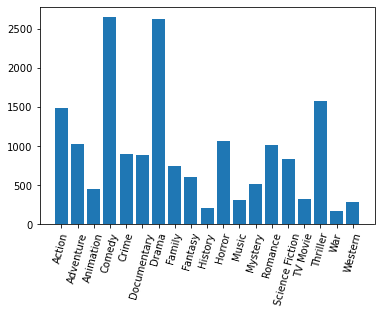

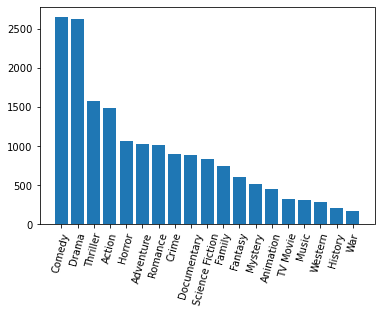

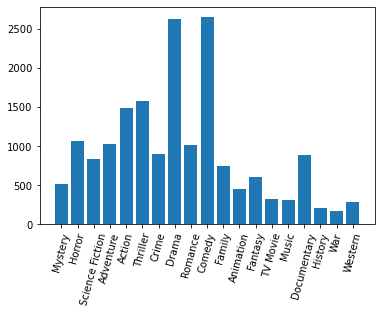

In [12]:
for order in ( alphabetical, genres_by_count, new_order):
    genre_counts = *( cc[genre] for genre in order),
    plt.xticks(ticks=np.arange( len( order)), labels=order, rotation= 75)
    plt.bar( order, genre_counts)
    plt.show()

## Genre Coincincence

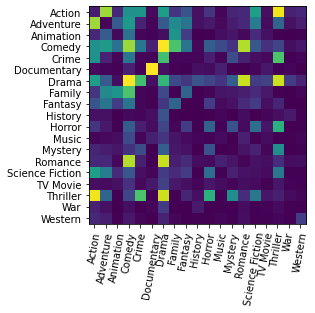

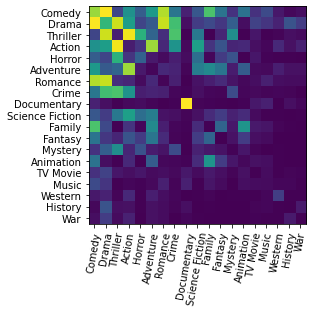

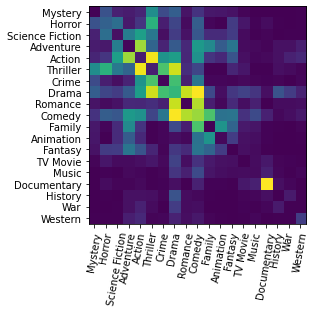

In [13]:
categorical_heatmap( ccc, order=alphabetical)
plt.show()
categorical_heatmap( ccc, order=genres_by_count)
plt.show()
categorical_heatmap( ccc, order=new_order)
plt.show()

## Connection Strength

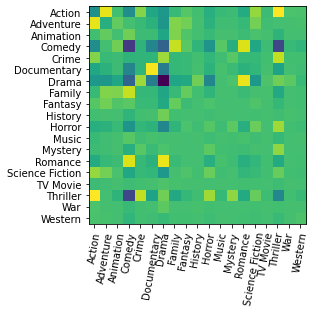

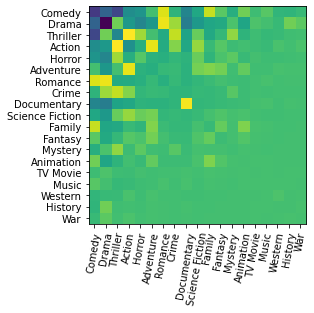

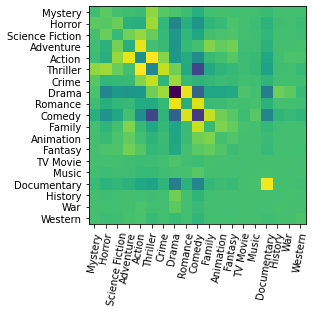

In [14]:
categorical_heatmap( connection_strength, order=alphabetical)
plt.show()
categorical_heatmap( connection_strength, order=genres_by_count)
plt.show()
categorical_heatmap( connection_strength, order=new_order)
plt.show()